# TVB for Epilepsy


### Basic configurations

In [3]:
!source activate python2.7.3
#!source activate python2_7

%matplotlib inline

import resource 
resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))

import sys
stdout = sys.stdout

import os

import numpy as np
from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
# input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH")
# head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "tests")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb") #, data_mode="java"
config.hypothesis.head_folder = head_folder
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
sys.stdout = stdout

2018-04-13 17:33:51,422 - WARNING - Plotter - Noninteractive matplotlib backend! No highlighting functionality in plots!


### Read data from tvb or Head folder

In [4]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD, seeg_sensors_files=[("seeg_xyz.txt",)])
# Plot
# plotter.plot_head(head)

2018-04-13 17:33:51,432 - INFO - __main__ - Reading from: /Users/dionperd/Dropbox/Work/VBtech/VEP/results/CC/TVB3/tvb


### Generate an hypothesis by manual definition 

In [5]:
# logger.info("\n\Reading hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(hypothesis_file)

# Formulate a VEP hypothesis manually
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)

# Regions of Pathological Excitability hypothesis:
x0_indices = [2, 25]
x0_values = [0.01, 0.01]
hyp_builder.set_x0_hypothesis(x0_indices, x0_values)

# Regions of Model Epileptogenicity hypothesis:
e_indices = list(range(head.connectivity.number_of_regions))
e_indices.remove(2)
e_indices.remove(25)
e_values = np.zeros((head.connectivity.number_of_regions, )) + 0.01
e_values[[1, 26]] = 0.99
e_values = np.delete(e_values, [2, 25]).tolist()
print(e_indices, e_values)
hyp_builder.set_e_hypothesis(e_indices, e_values)

# Regions of Connectivity hypothesis:
w_indices = [] # [(0, 1), (0, 2)] 
w_values = [] # [0.5, 2.0] 
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hyp_builder.build_hypothesis()

([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86], [0.01, 0.99, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])


### ...or by reading from epileptogenicity file...

In [6]:
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
# Read clinical hypothesis 
hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)
e_indices = [1, 26]# [1, 2, 25, 26]
hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices) 
# Change something manually if necessary
hypothesis.x0_values = [0.01, 0.01]

### Print hypothesis

In [7]:
disease_indices = hypothesis.get_regions_disease_indices()
disease_values = hypothesis.get_regions_disease_values()
w_indices = hypothesis.get_connectivity_disease_indices()
w_values = hypothesis.get_connectivity_disease_values()
n_w = len(w_indices)
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
print(hypothesis)
print(hypothesis.string_regions_disease(head.connectivity.region_labels))
print(hypothesis.string_connectivity_disease(head.connectivity.region_labels))

DiseaseHypothesis{
07. Epileptogenicity (E) disease indices = [ 0.98716938  0.99000001]
05. Excitability (x0) disease values = [0.01, 0.01]
04. Excitability (x0) disease indices = [2, 25]
09. Connectivity (W) disease values = []
02. Type = Excitability_Epileptogenicity
06. Epileptogenicity (E) disease indices = [1, 26]
08. Connectivity (W) disease indices = []
11. Propagation strengths of indices = []
01. Name = e_x0_Hypothesis
03. Number of regions = 87
10. Propagation indices = []}
1. ctx-lh-caudalanteriorcingulate: E=0.987169384956
2. ctx-lh-caudalmiddlefrontal: x0=0.01
25. ctx-lh-rostralmiddlefrontal: x0=0.01
26. ctx-lh-superiorfrontal: E=0.990000009537



### Generate model configuration from hypothesis

2018-04-13 17:34:02,091 - INFO - __main__ - 

Running hypothesis: e_x0_Hypothesis
2018-04-13 17:34:02,097 - INFO - __main__ - 

Creating model configuration...
1: E=0.987169384956
2: x0=0.01
25: x0=0.01
26: E=0.990000009537
K = 3.44828
x0_max = -0.312459869738
x0_min = -2.46018587724


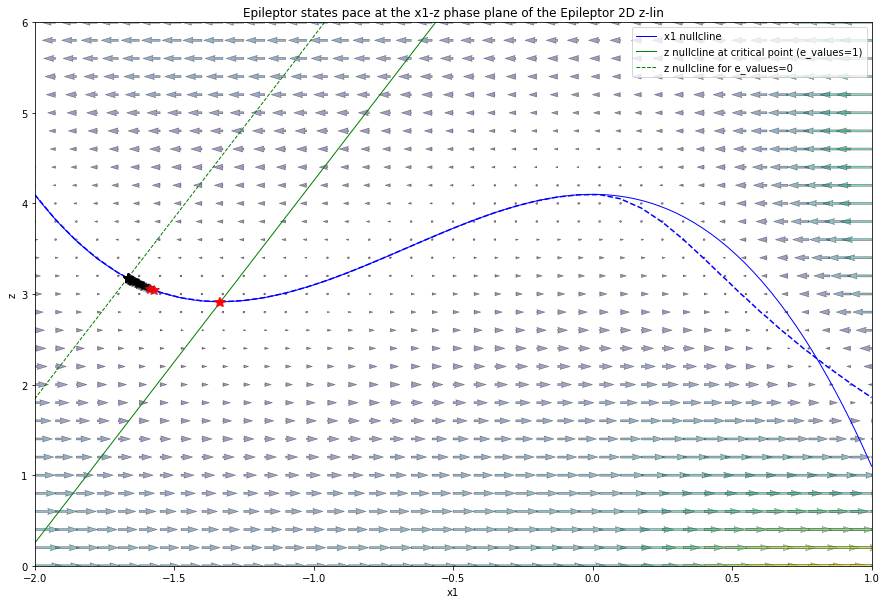

In [8]:
# logger.info("\n\nReading model configuration from file...")
# model_configuration = reader.read_model_configuration(model_config_file)

from tvb_epilepsy.service.model_configuration_builder import ModelConfigurationBuilder
from tvb_epilepsy.base.constants.model_constants import K_DEF

logger.info("\n\nRunning hypothesis: " + hypothesis.name)
logger.info("\n\nCreating model configuration...")
K = 3*K_DEF # in the case of the above hypothesis read from file
# K = 5*K_DEF # in the case of the above manual hypothesis
model_config_builder = ModelConfigurationBuilder(hypothesis.number_of_regions, K=K)
mcs_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_model_config_service.h5")
writer.write_model_configuration_builder(model_config_builder, mcs_file)
print(hypothesis.string_regions_disease())
# Assume all healthy nodes have x0_values = 0.0:
model_configuration = model_config_builder.build_model_from_hypothesis(hypothesis, head.connectivity.normalized_weights)
# # Assume all healthy nodes have e_values = 0.0
# model_configuration = model_config_builder.build_model_from_E_hypothesis(hypothesis, head.connectivity.normalized_weights)
print "K =", np.mean(model_configuration.K)
print "x0_max =", np.max(model_configuration.x0)
print "x0_min =", np.min(model_configuration.x0)
mc_path = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ModelConfig.h5")
# writer.write_model_configuration(model_configuration, mc_path)
# Plot nullclines and equilibria of model configuration
plotter.plot_state_space(model_configuration, "2D", head.connectivity.region_labels, 
                         special_idx=hypothesis.x0_indices + hypothesis.e_indices, 
                         figure_name=hypothesis.name + "_StateSpace")

### Run linear stability analysis

2018-04-13 17:34:07,730 - INFO - __main__ - 

Running LSA...
DiseaseHypothesis{
07. Epileptogenicity (E) disease indices = [ 0.98716938  0.99      ]
05. Excitability (x0) disease values = [ 0.00999999  0.00999999]
04. Excitability (x0) disease indices = [2, 25]
09. Connectivity (W) disease values = []
02. Type = Excitability_Epileptogenicity
06. Epileptogenicity (E) disease indices = [1, 26]
08. Connectivity (W) disease indices = []
11. Propagation strengths of indices = [ 0.13224357  0.74639001]
01. Name = e_x0_Hypothesis_LSA
03. Number of regions = 87
10. Propagation indices = [ 1 26]}


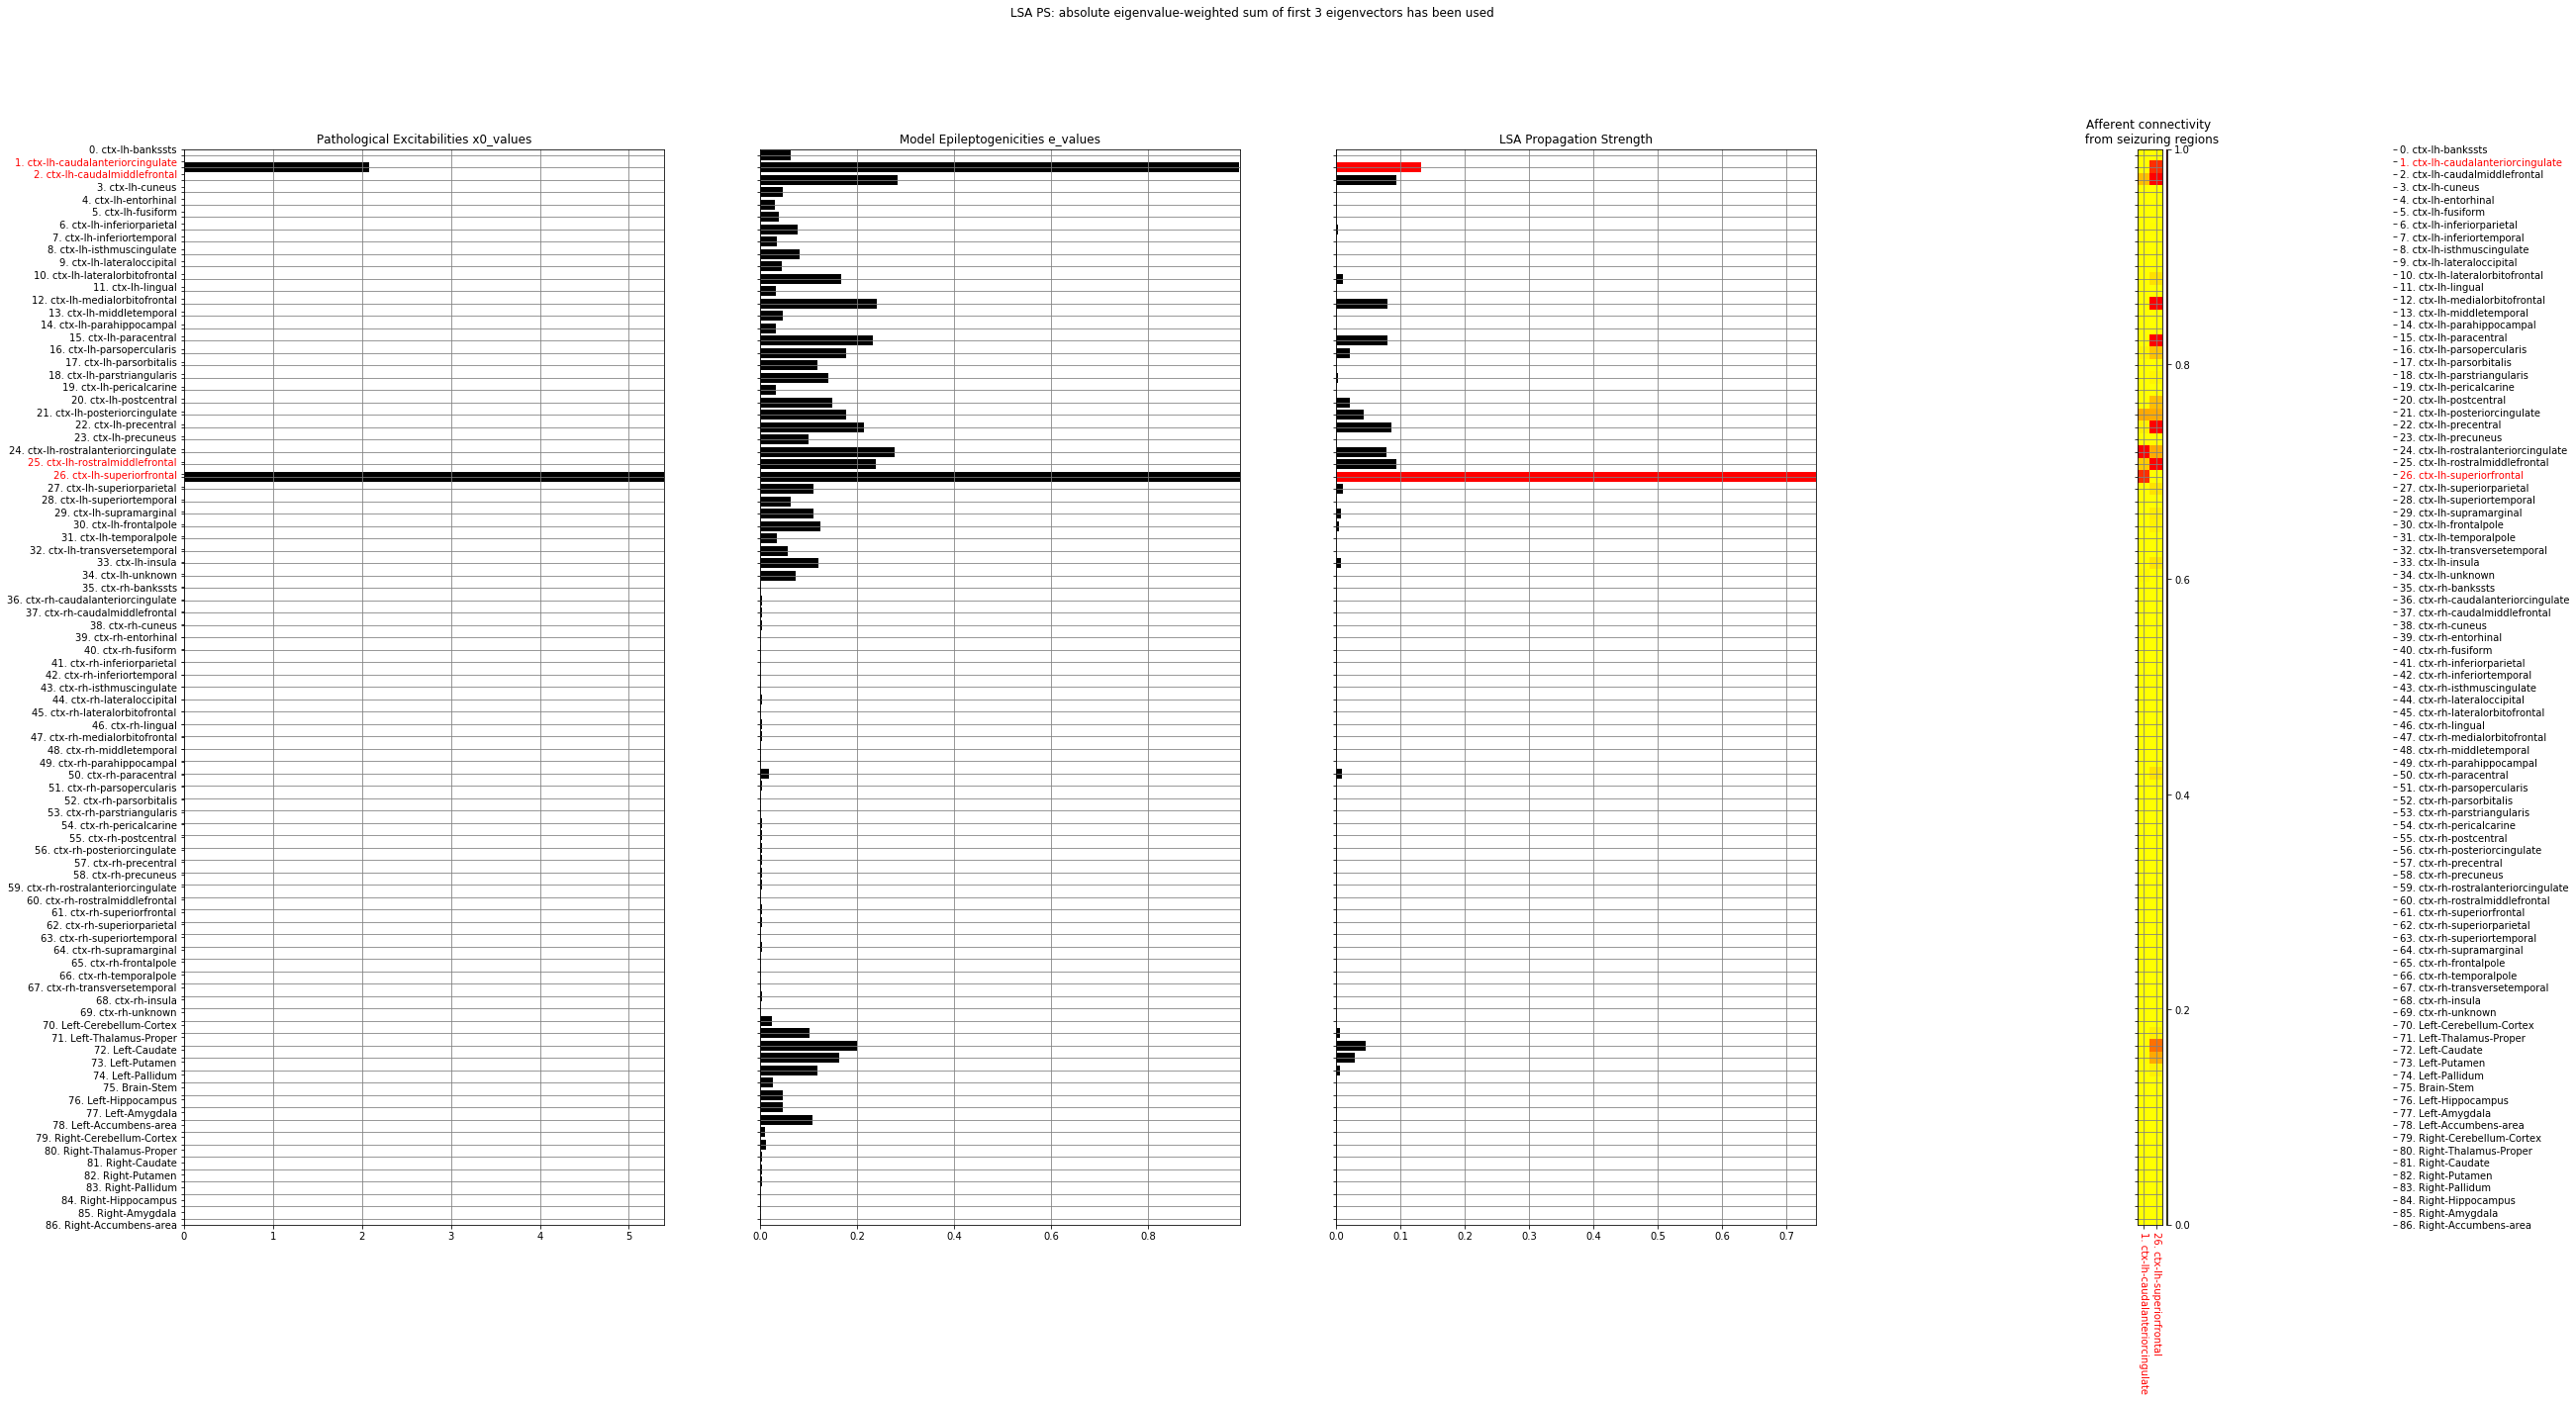

In [9]:
# Run linear stability analysis
# logger.info("\n\Reading LSA hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(lsa_hypothesis_file)
from tvb_epilepsy.service.lsa_service import LSAService
logger.info("\n\nRunning LSA...")
# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True, 
                         normalize_propagation_strength=False)
lsa_hypothesis = lsa_service.run_lsa(hypothesis, model_configuration)
print(lsa_hypothesis)
lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")
lsa_config_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
# writer.write_hypothesis(lsa_hypothesis, lsa_path)

# Plot
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, None);


### Run parameter search exploration for linear stability analysis around the clinical hypothesis

2018-04-13 17:34:17,084 - INFO - __main__ - 

Running PSE LSA...
2018-04-13 17:34:17,187 - WARNING - tvb_epilepsy.service.sampling.stochastic_sampling_service - Input parameters' size (1) larger than the one implied by input parameters's shape (83)!
Modifying input parameters' size accordingly!

Generated a parameter search exploration for lsa/sim task,
with 88 parameters of 100 values each,
leading to 100 total execution loops

Executing loop 1 of 100
2018-04-13 17:34:17,788 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[26]]  = [-1.33422649]
were corrected for LSA to value: X1EQ_CR_DEF - 10 ** (-3) = -1.33433333333 to be sub-critical!
2018-04-13 17:34:17,929 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[26]]  = [-1.33383751]
were corrected for LSA to value: X1EQ_CR_DEF - 10 ** (-3) = -1.33433333333 to be sub-critical!

Executing loop 10 of 100
2018-04-13 17:34:18,242 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[26]]  = [-1.3342593

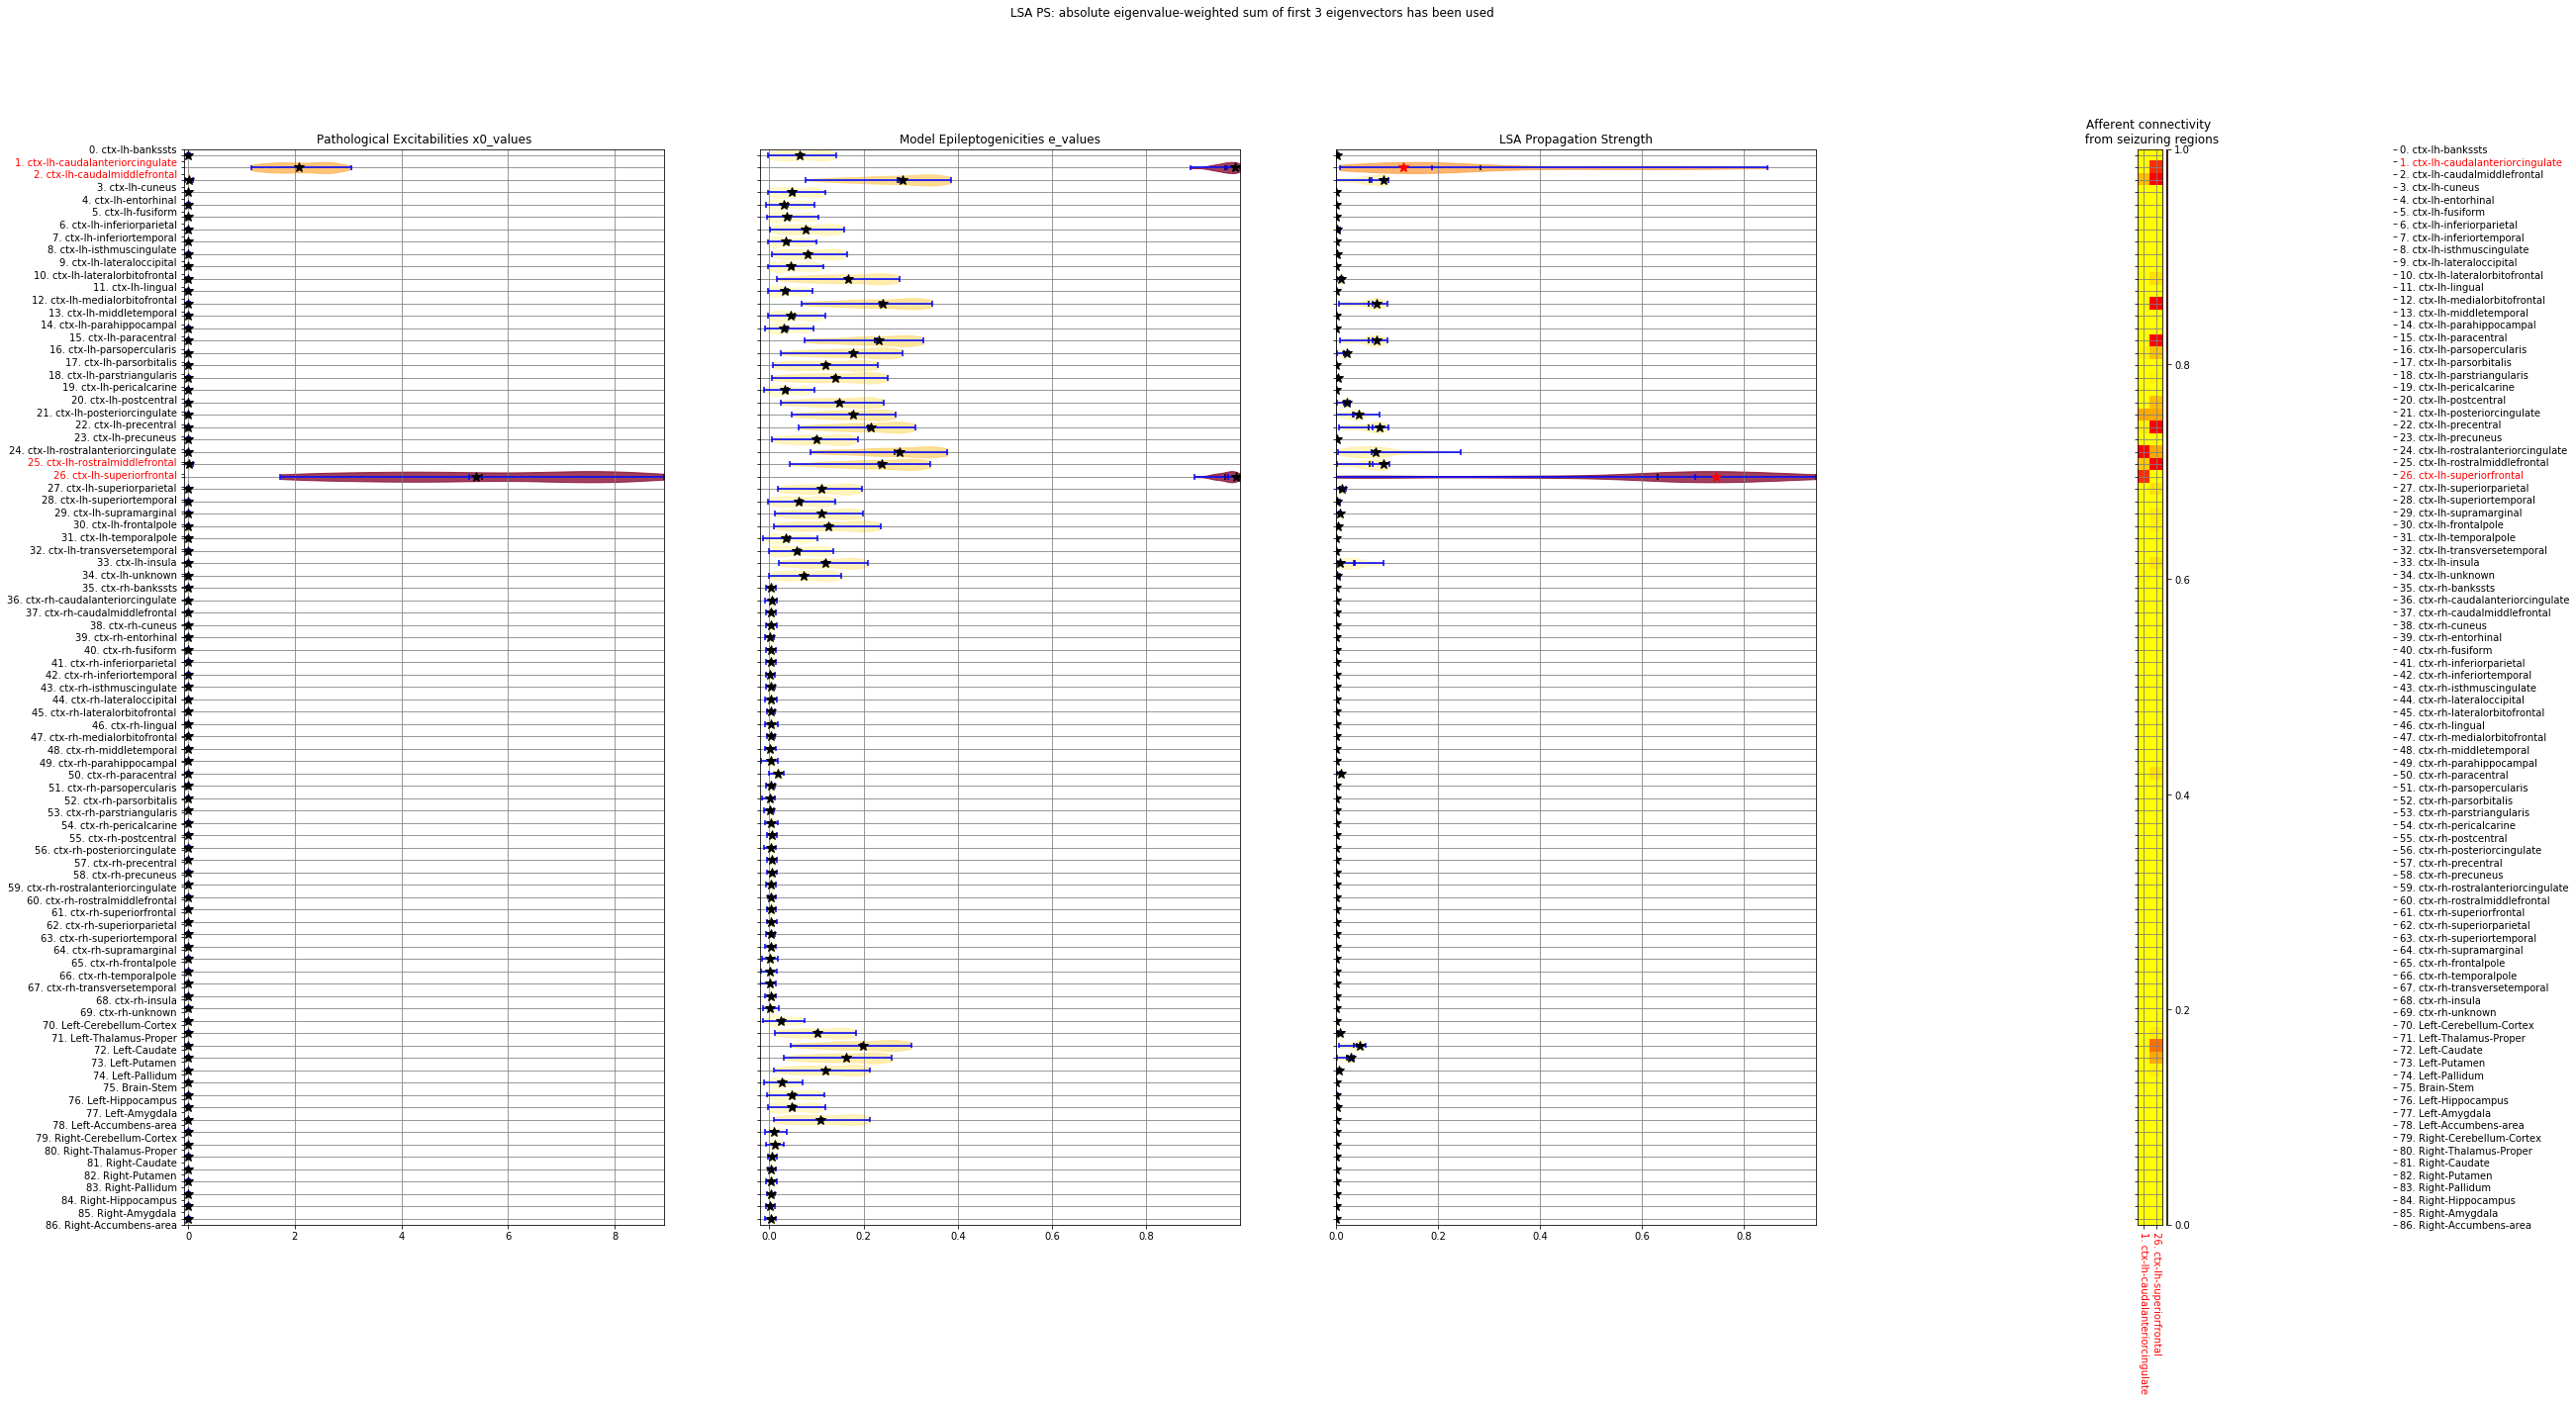

In [10]:
from tvb_epilepsy.top.scripts.pse_scripts import pse_from_lsa_hypothesis
# --------------Parameter Search Exploration (PSE)-------------------------------
logger.info("\n\nRunning PSE LSA...")
n_samples = 100
pse_results = pse_from_lsa_hypothesis(n_samples, lsa_hypothesis, 
                                      head.connectivity.normalized_weights,
                                      model_config_builder, lsa_service,
                                      head.connectivity.region_labels,
                                      param_range=0.1,
                                      global_coupling=[{"indices": all_regions_indices}],
                                      healthy_regions_parameters=[
                                                        {"name": "x0_values", "indices": healthy_indices}],
                                     logger=logger, save_flag=True)[0]
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                lsa_service.eigen_vectors_number, head.connectivity.region_labels, pse_results)

pse_lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_results.h5")
# writer.write_dictionary(pse_results, pse_lsa_path)

### Prepare simulation

2018-04-13 17:34:52,285 - INFO - __main__ - 

Configuring simulation from model_configuration...
2018-04-13 17:34:52,520 - INFO - __main__ - 

Simulating...
...100.0% done in 695.372061014 secs

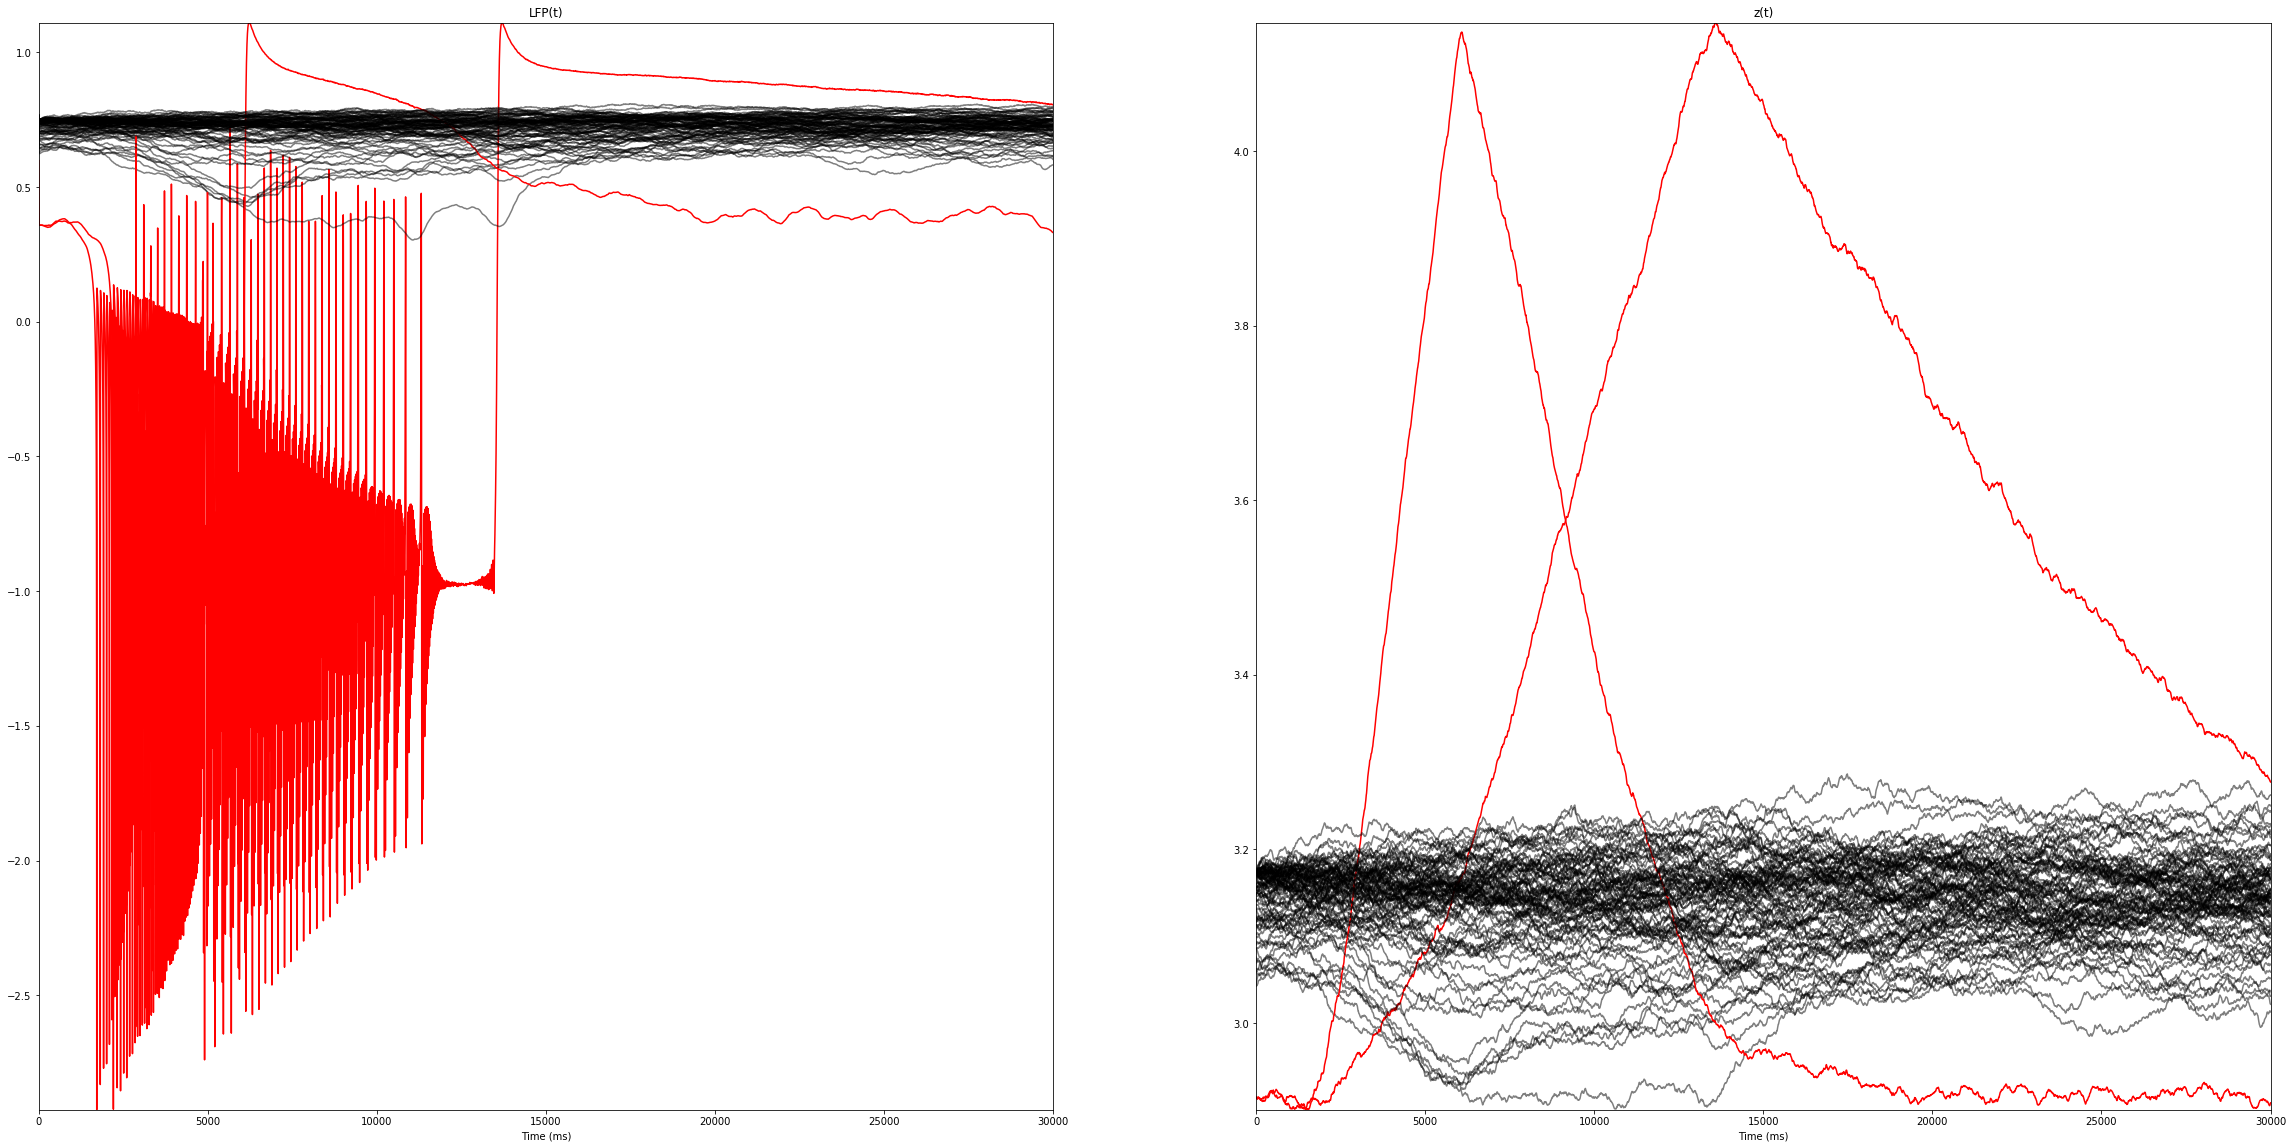

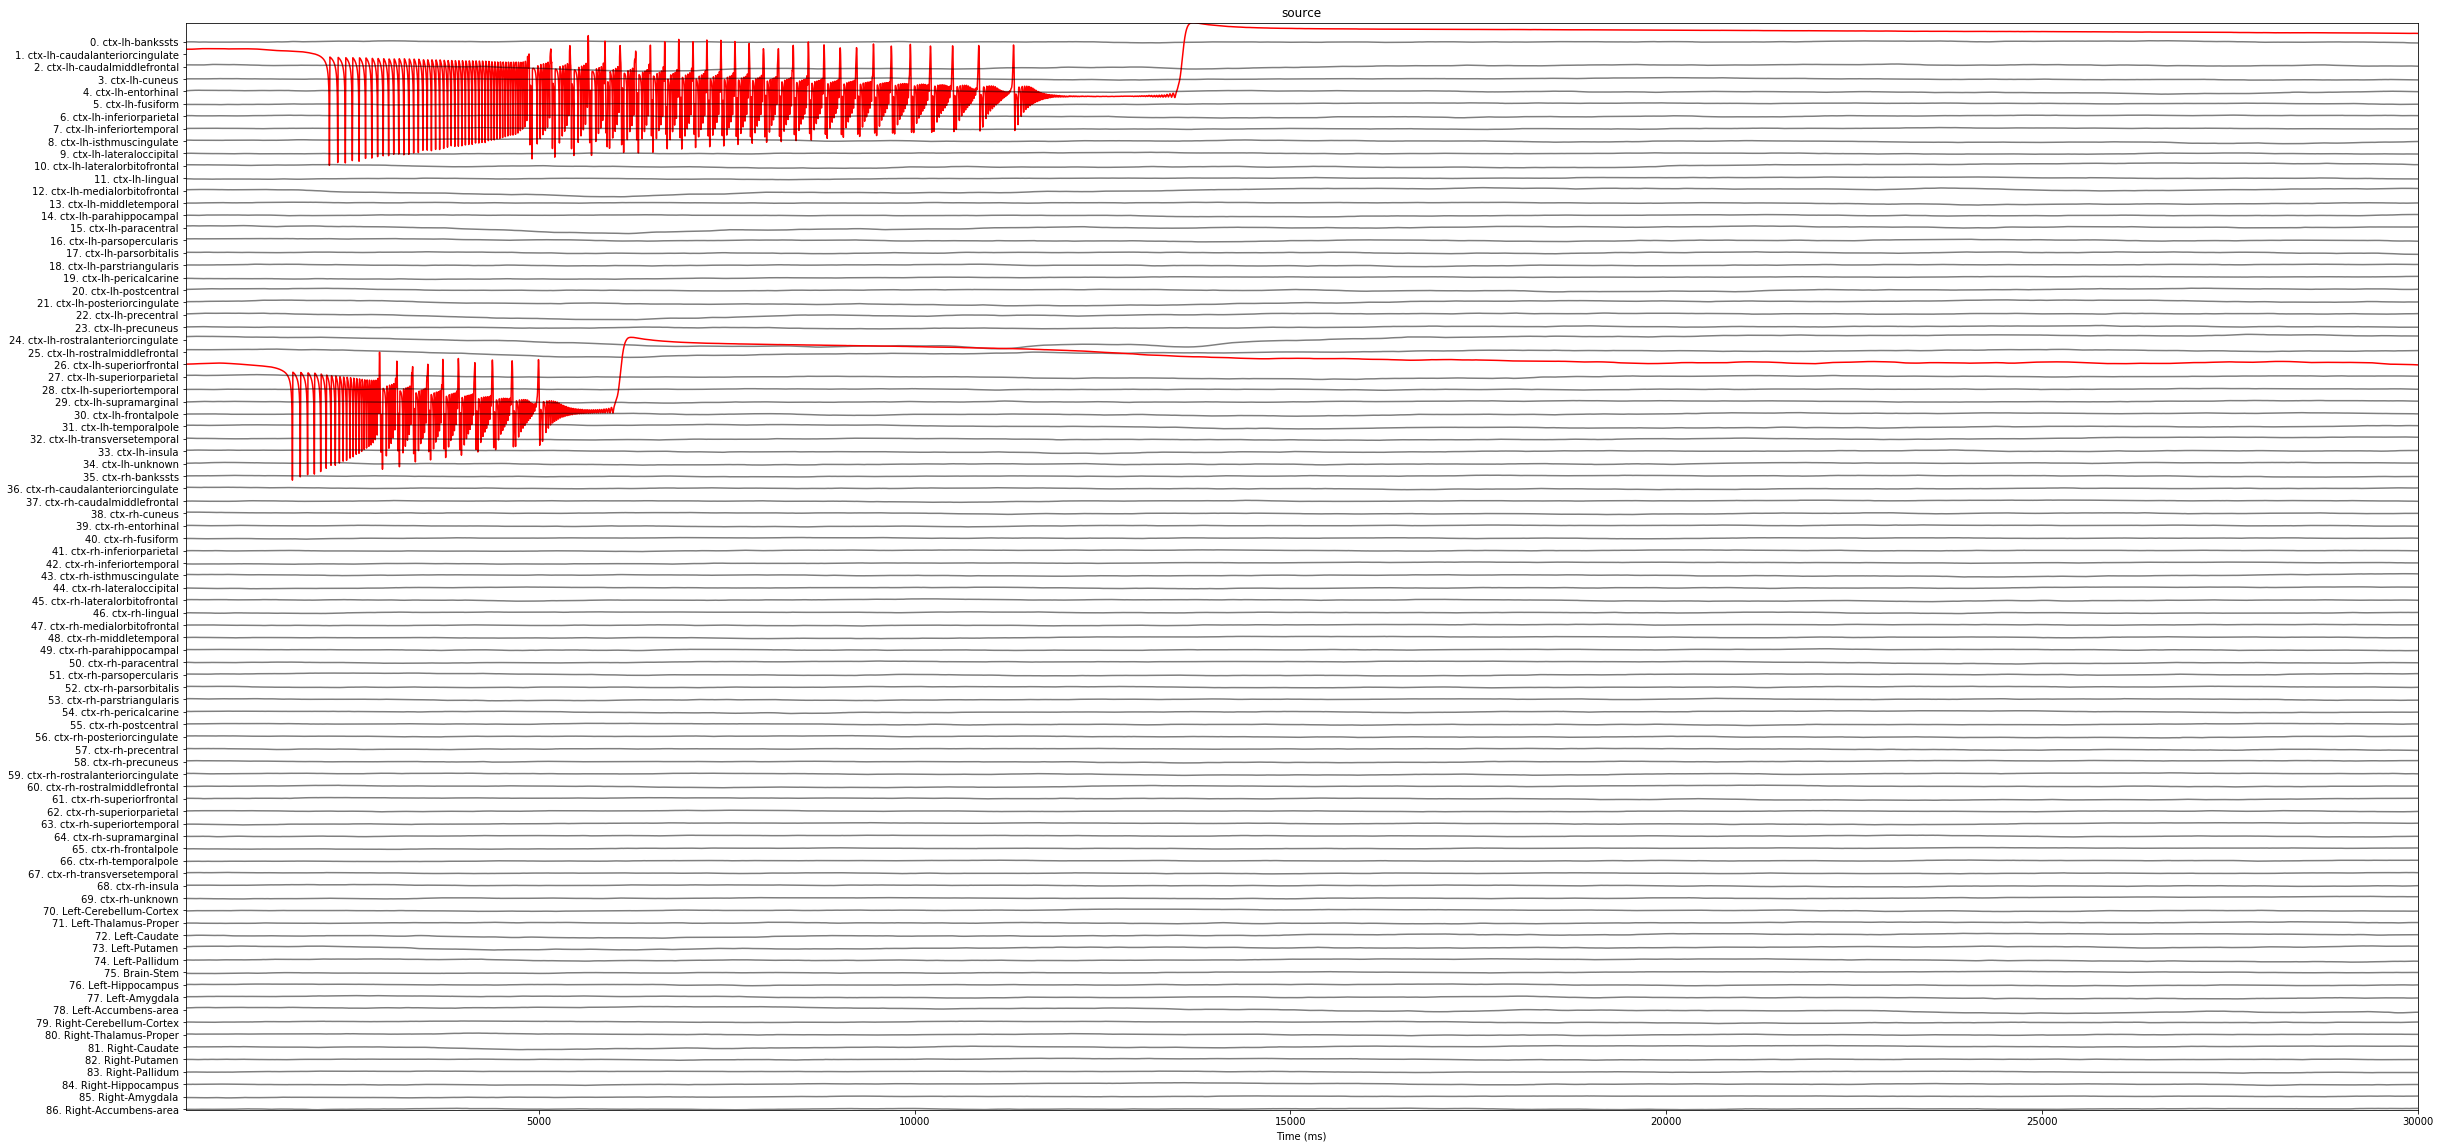

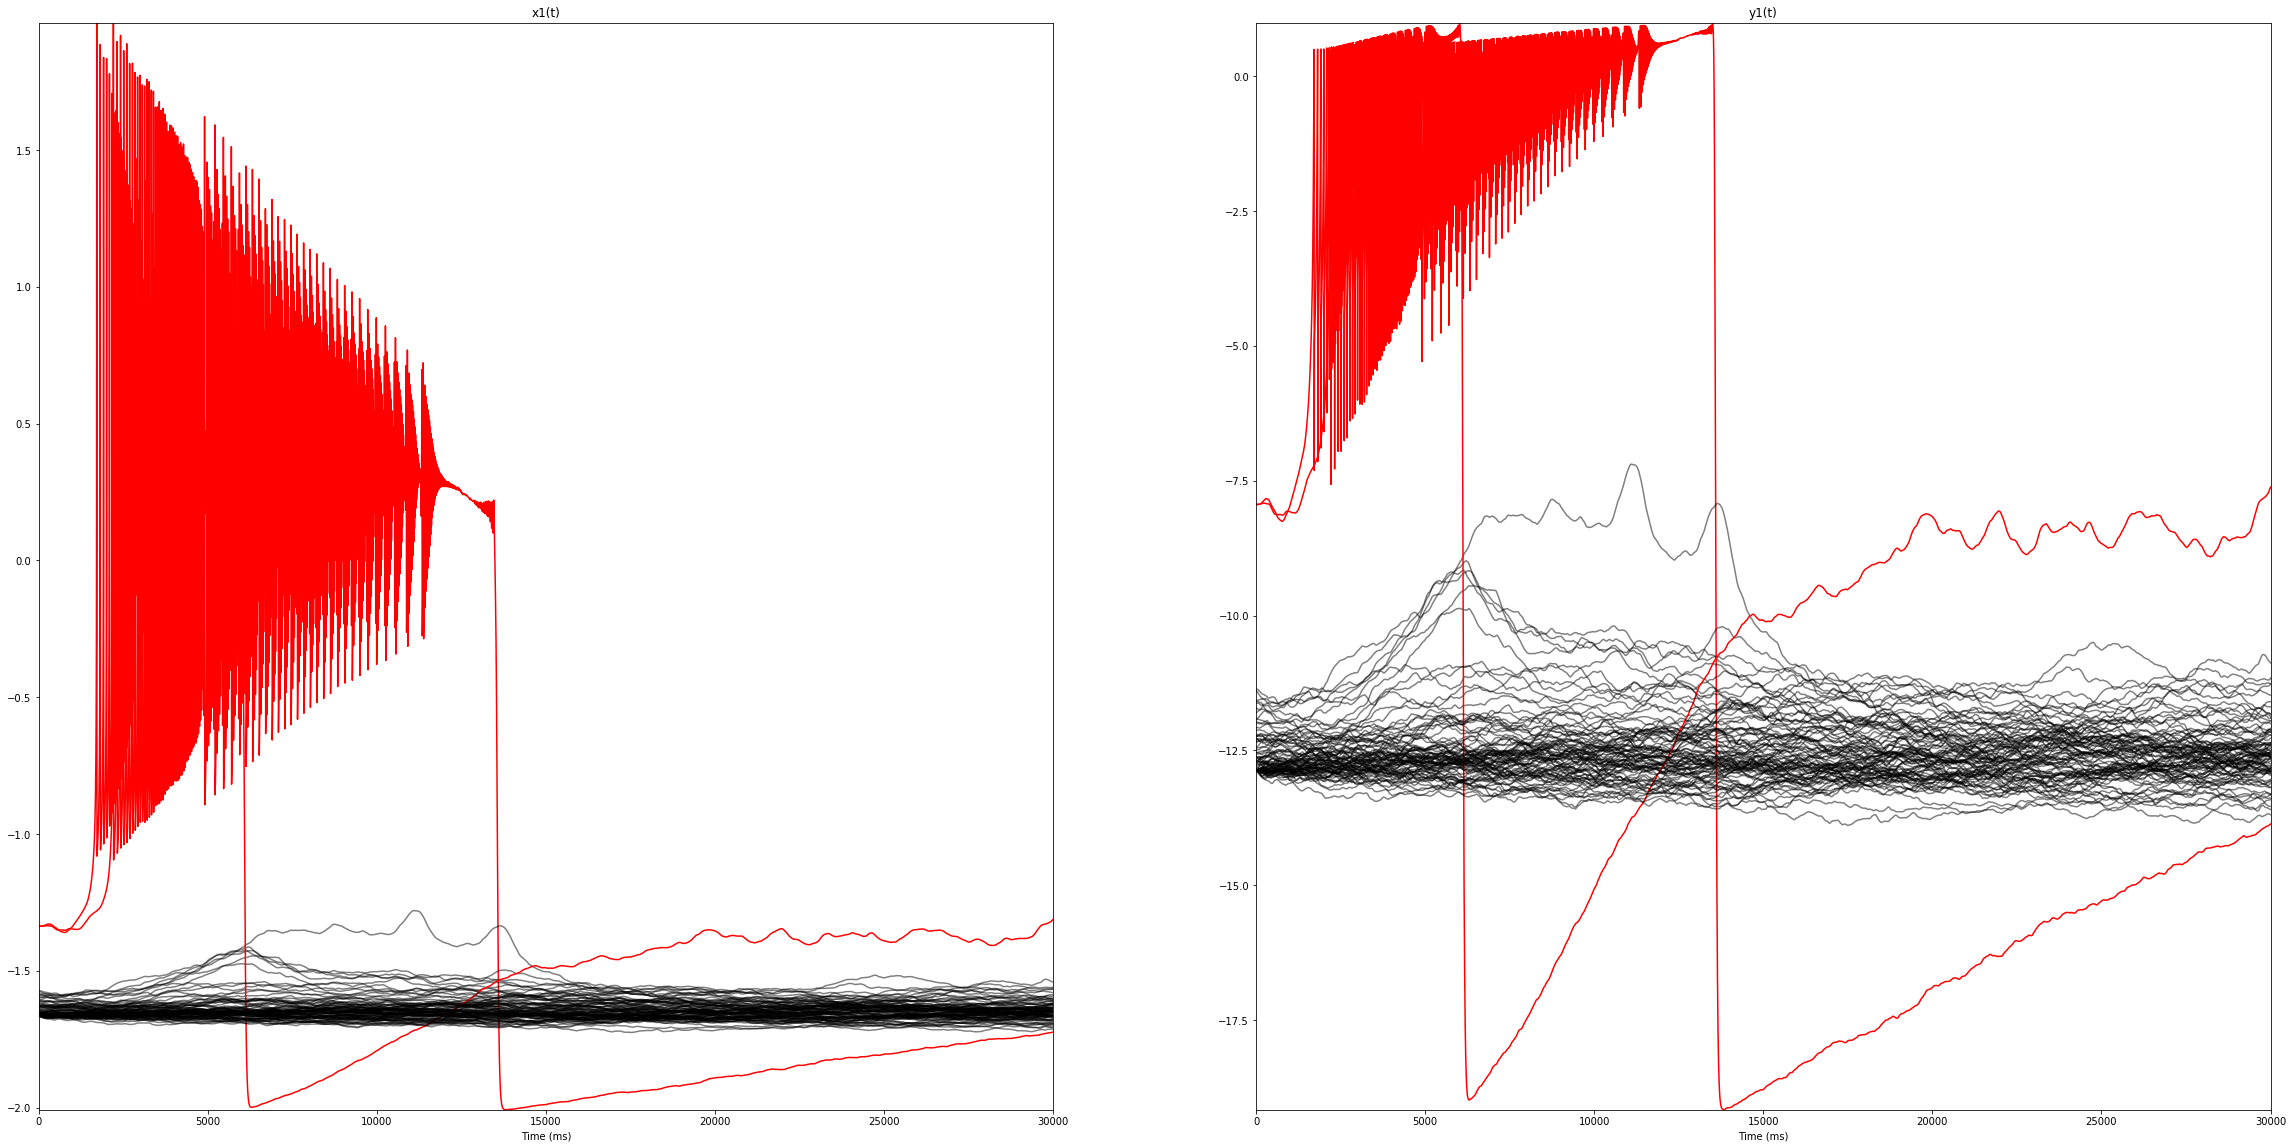

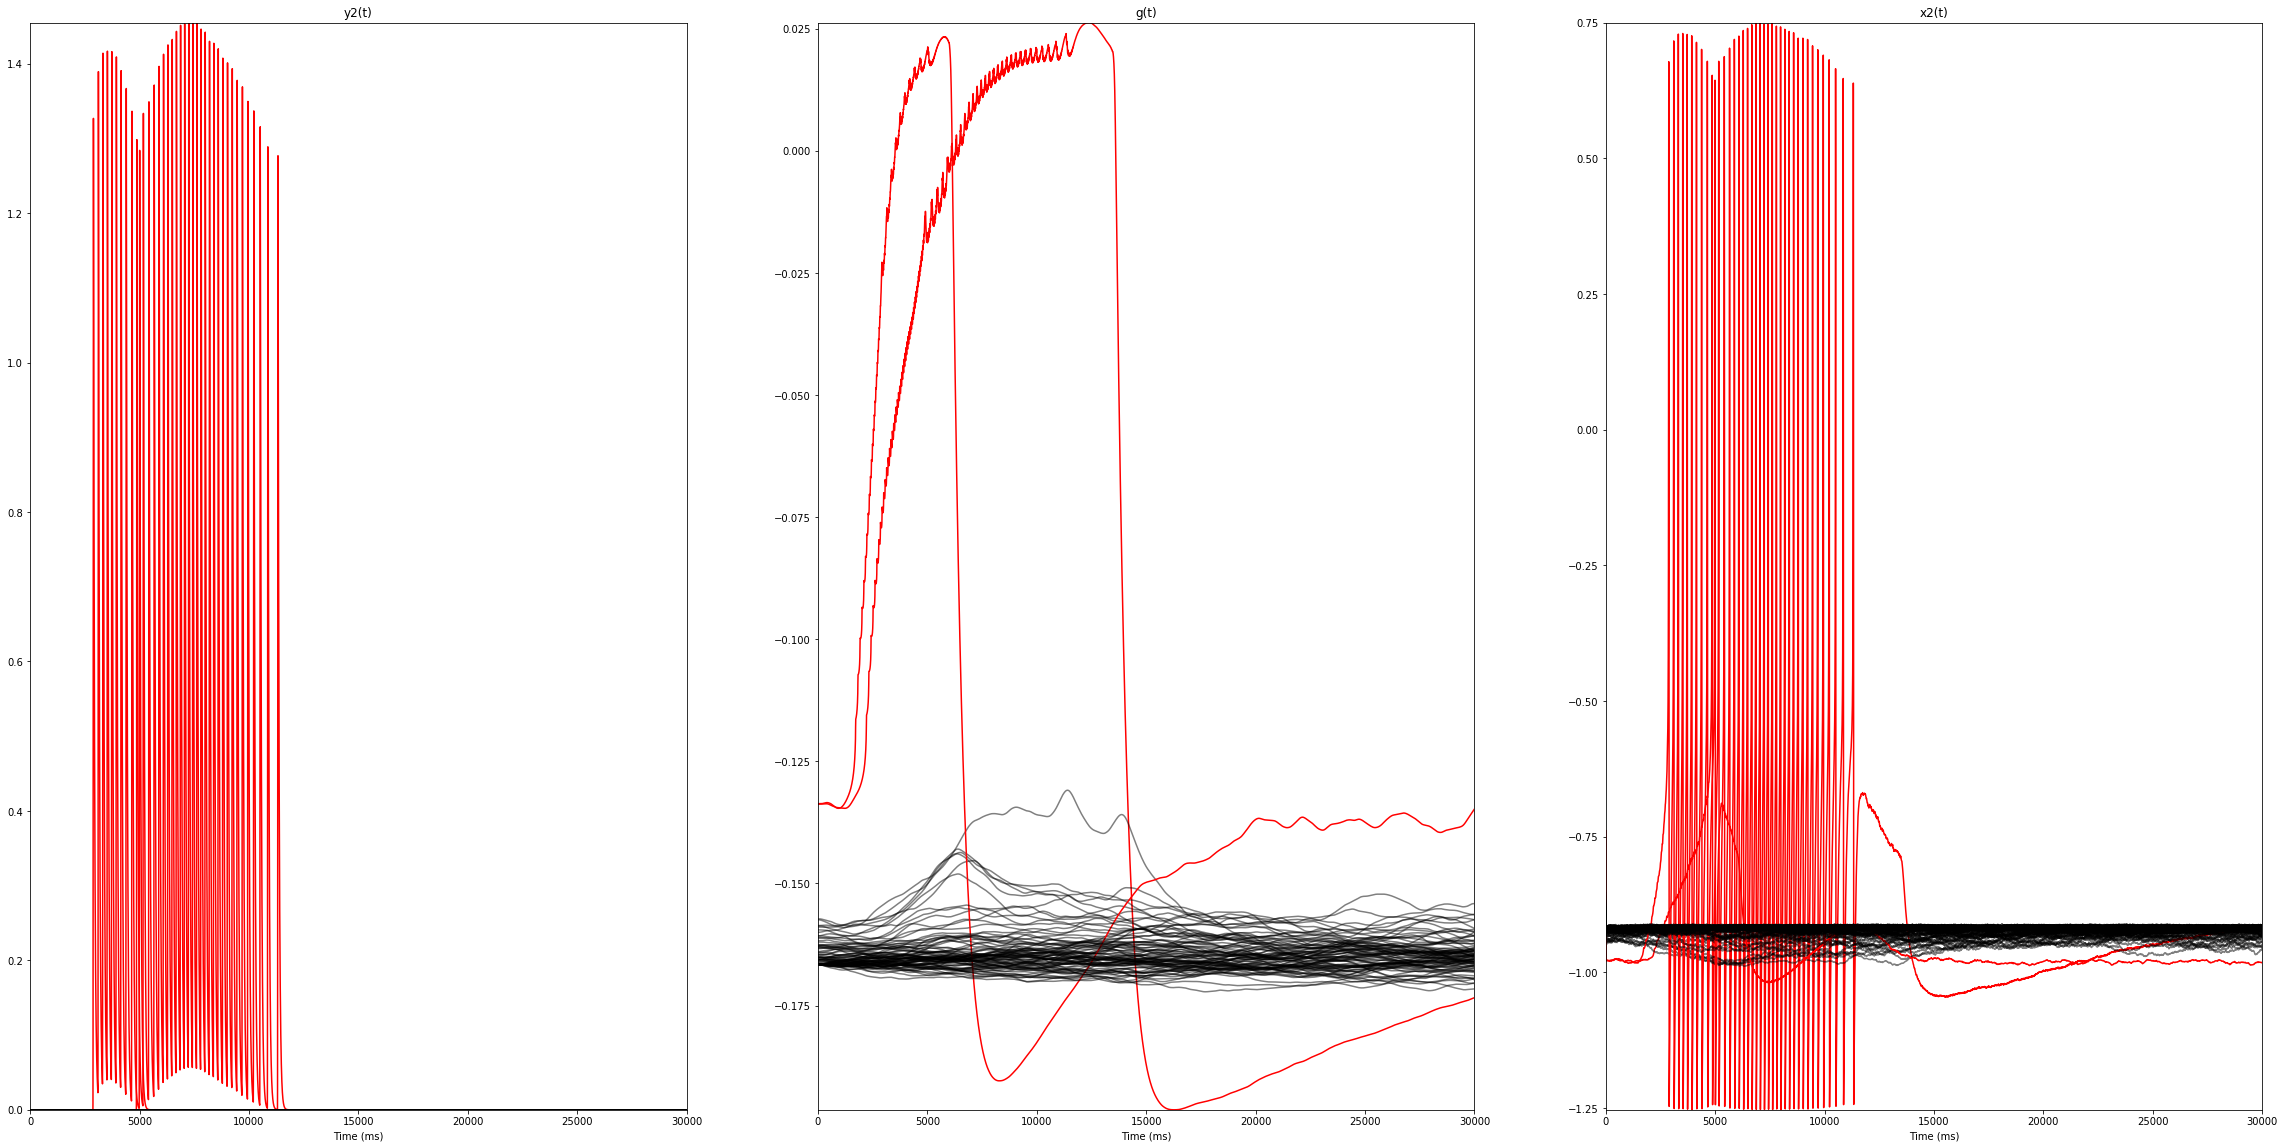

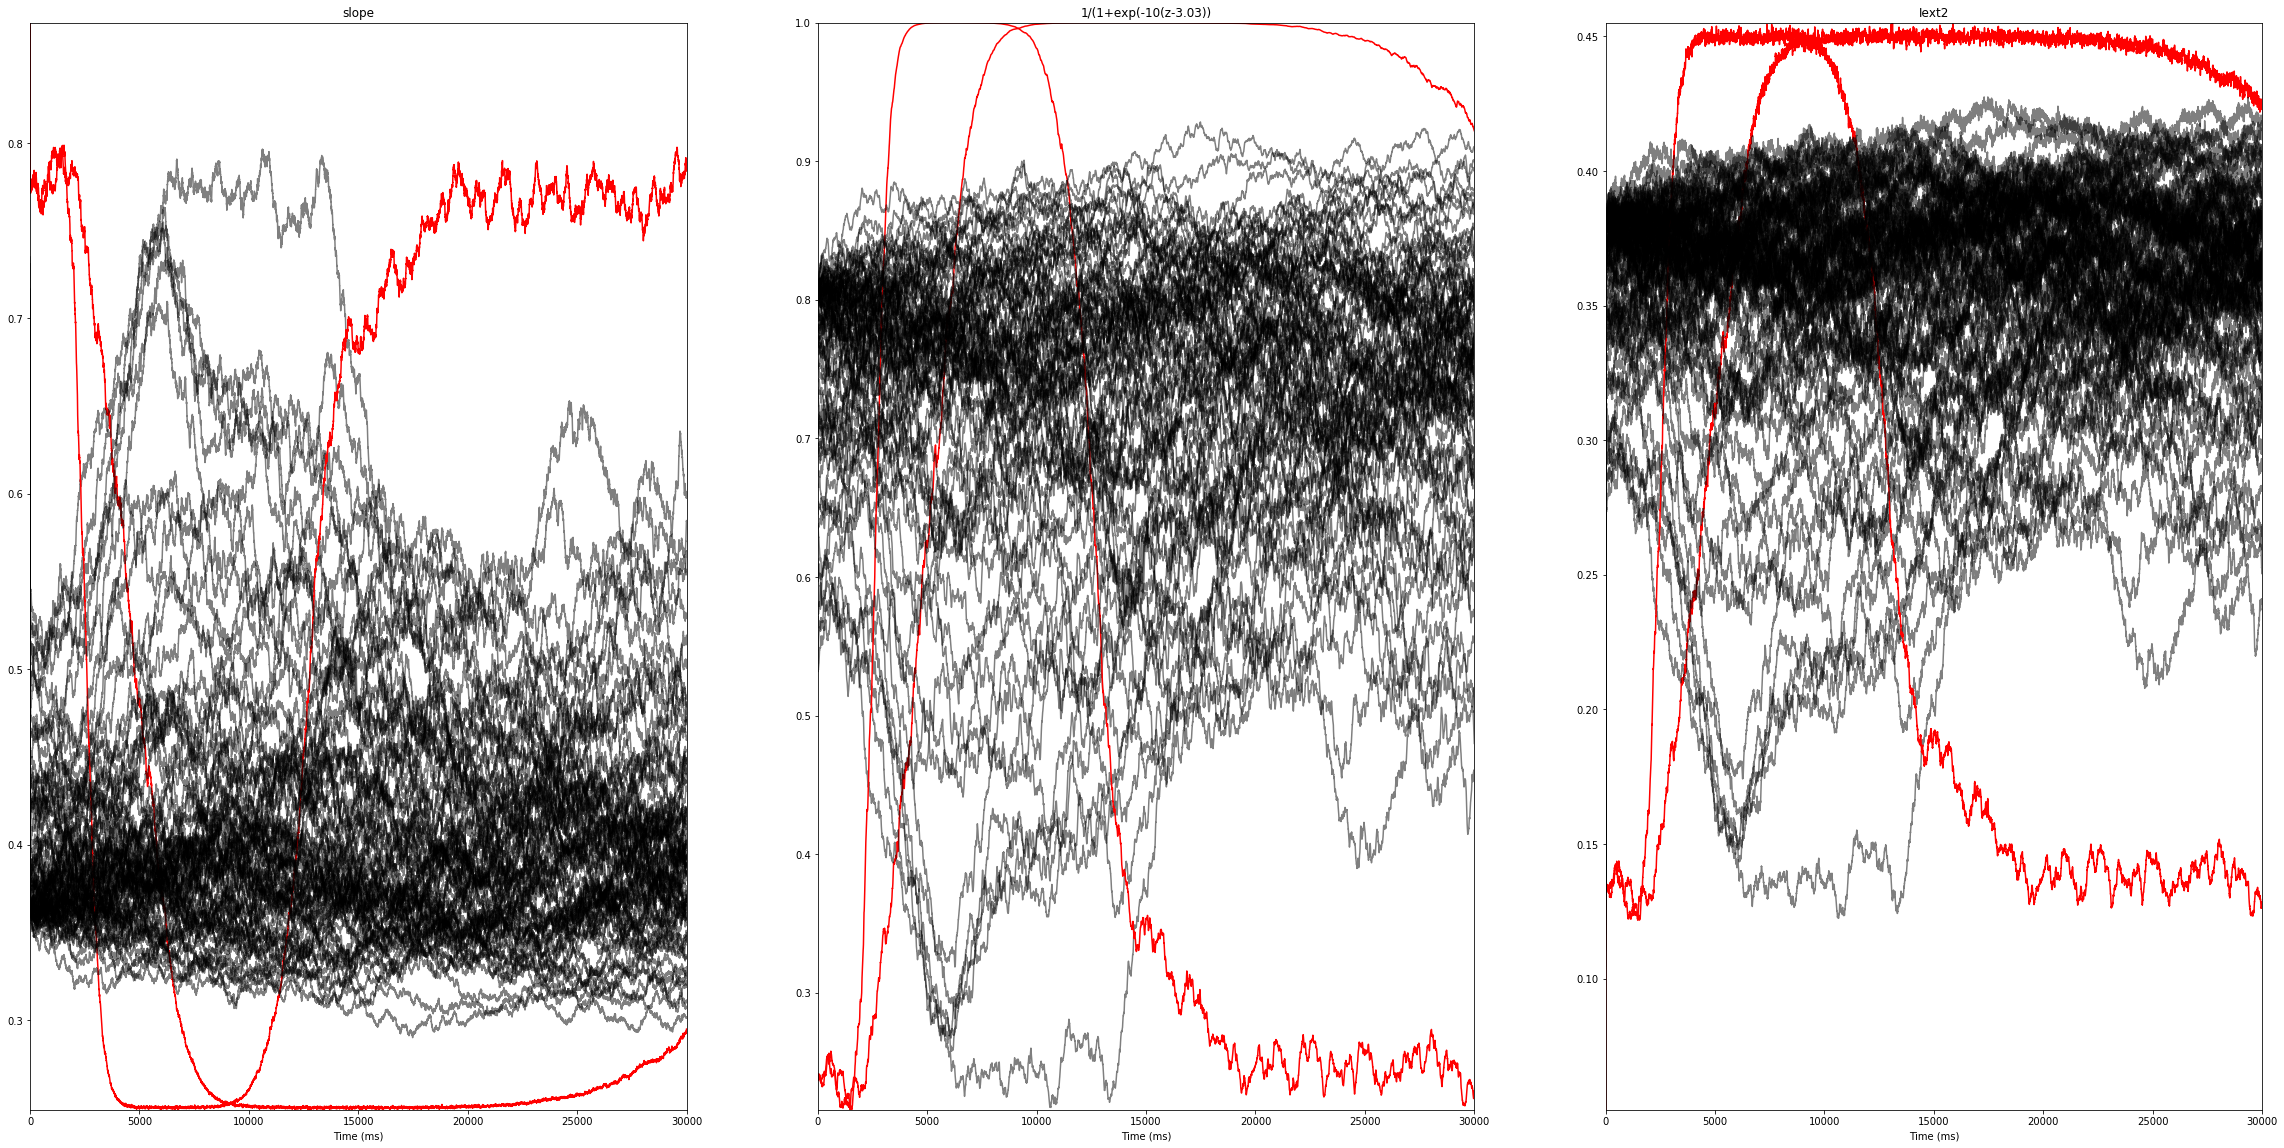

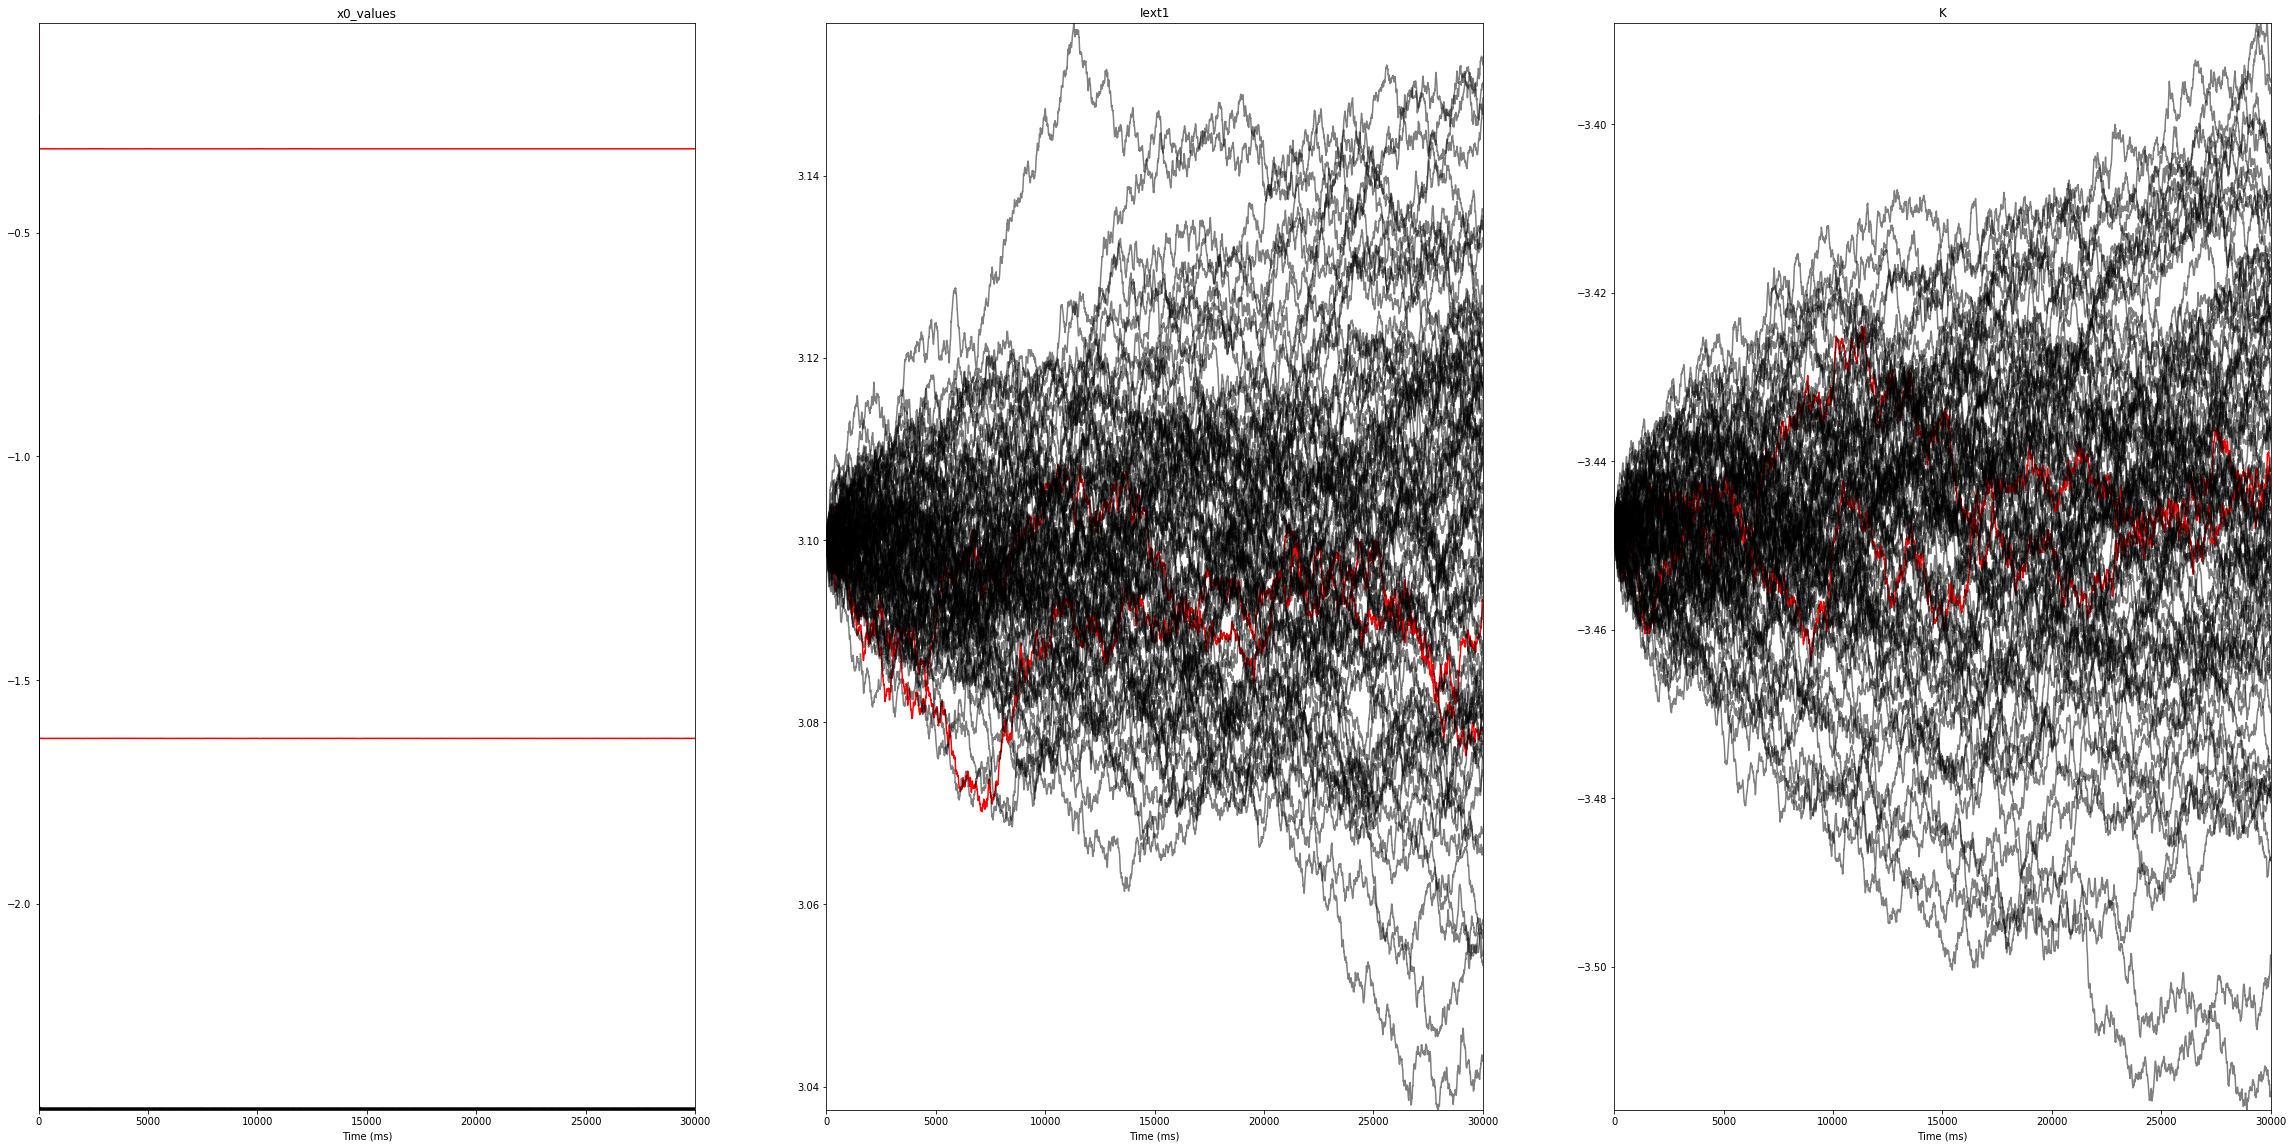

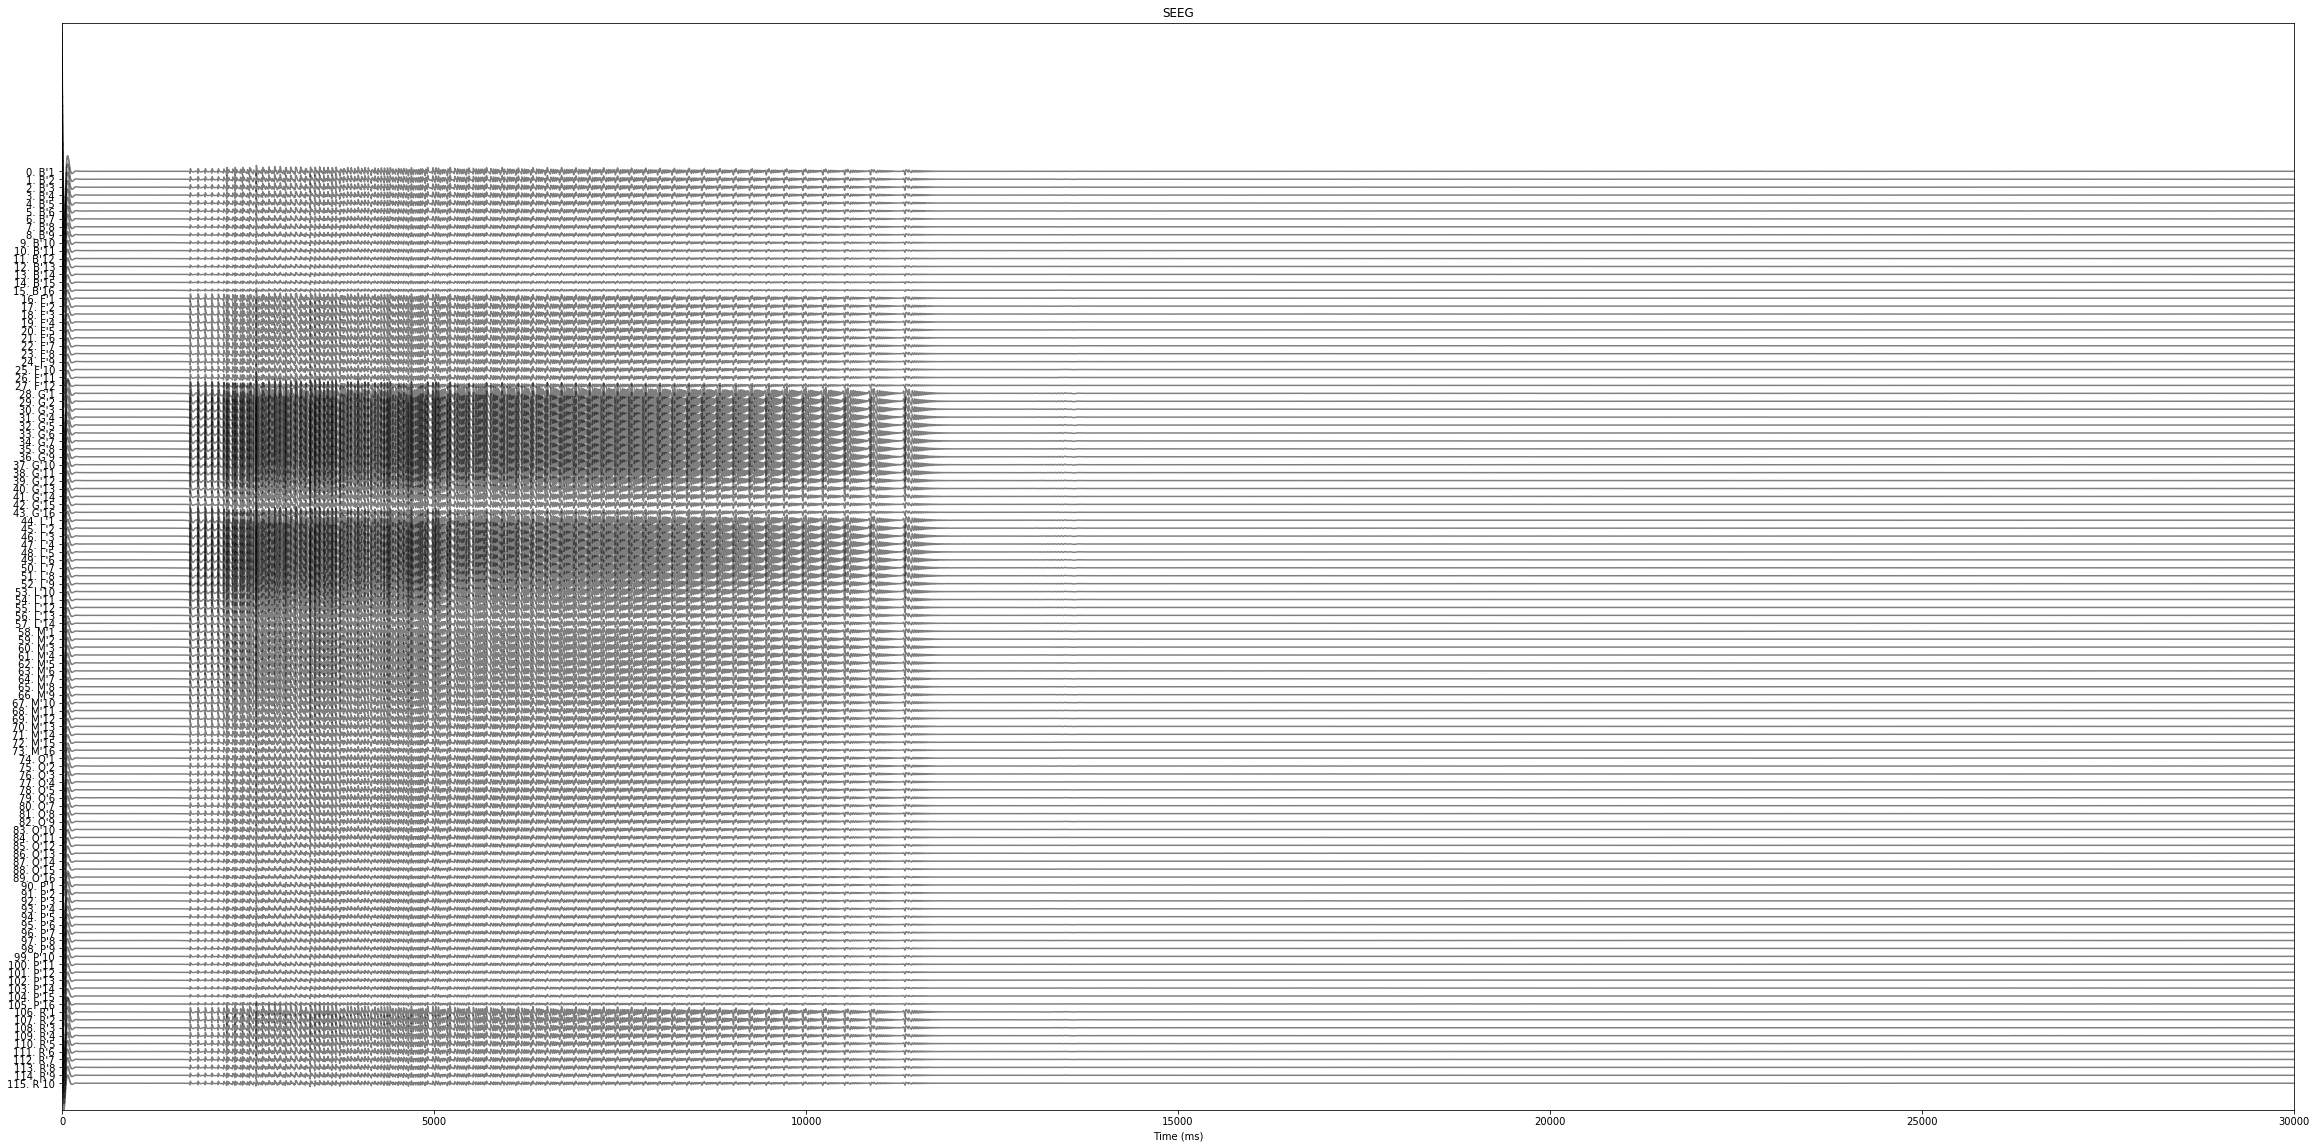

In [12]:
from collections import OrderedDict
from tvb_epilepsy.base.model.timeseries import Timeseries, TimeseriesDimensions
from tvb_epilepsy.service.simulator.simulator_builder import SimulatorBuilder
from tvb_epilepsy.top.scripts.simulation_scripts import compute_seeg_and_write_ts_to_h5

# --------------------------Simulation-----------------------------------
sim_type = "realistic" #"tvb" # "fitting"
logger.info("\n\nConfiguring simulation from model_configuration...")
# If you choose model...
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations,
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables,
#      -Iext2 and |slope are coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -multiplicative correlated noise is also used
# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0
sim_builder = SimulatorBuilder(config.simulator.MODE)
# sim_settings = reader.read_simulation_settings(sim_settings_file)
# First set model name, then build settings!
report_every_n_monitor_step=100
if sim_type == "realistic":
    model = sim_builder.set_model_name("EpileptorDPrealistic").generate_model_tvb(model_configuration)
    model.tau0 = 30000.0
    model.tau1 = 0.2
    model.slope = 0.25
    sim_settings = sim_builder.set_simulated_period(30000).build_sim_settings()
    from tvb_epilepsy.base.constants.model_constants import COLORED_NOISE
    sim_settings.noise_type = COLORED_NOISE
    sim_settings.noise_ntau = 10
    report_every_n_monitor_step=1000
elif sim_type == "fitting":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model_tvb(model_configuration)
    model.tau0 = 300.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(2048.0).set_simulated_period(2000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-5]
elif sim_type == "reduced":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model_tvb(model_configuration)
    model.tau0 = 2857.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(2048.0).set_simulated_period(5000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-7]
elif sim_type == "tvb":
   model = sim_builder.set_model_name("Epileptor").generate_model_tvb(model_configuration)
   sim_settings = sim_builder.set_simulated_period(5000).build_sim_settings()
else:
   model = sim_builder.generate_model(model_configuration)
   sim_settings = sim_builder.build_sim_settings()  # "EpileptorDP" by default

sim, sim_settings, model = sim_builder.build_simulator_TVB_from_model_sim_settings(model_configuration, 
                                                                                   head.connectivity, model, sim_settings)

sim_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_sim_settings.h5")
# writer.write_simulation_settings(sim.simulation_settings, sim_path)
# writer.write_generic(sim.model, config.out.FOLDER_RES, lsa_hypothesis.name + "_sim_model.h5")


### Simulate

In [ ]:
# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
logger.info("\n\nSimulating...")
sim_output = []
seeg=[]
sim_output, status = sim.launch_simulation(report_every_n_monitor_steps=100)

if not status:
    logger.warning("\nSimulation failed!")
else:
    sim_output, seeg = \
        compute_seeg_and_write_ts_to_h5(sim_output, sim.model, head.sensorsSEEG,
                                        os.path.join(config.out.FOLDER_RES, sim.model._ui_name + "_ts.h5"),
                                        seeg_gain_mode="lin",hpf_flag=True, hpf_low=10.0, hpf_high=512.0)
     
    # Plot results 
    plotter.plot_simulated_timeseries(sim_output, sim.model, lsa_hypothesis.lsa_propagation_indices, 
                                      seeg_list=seeg, spectral_raster_plot=False, hpf_flag=False, log_scale=True)